In [ ]:
# TPSFEB22-01 EDA which makes sense

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import factorial

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

elements = [e for e in train_df.columns if e != 'row_id' and e != 'target']

# Convert the 10 bacteria names to the integers 0 .. 9
le = LabelEncoder()
train_df['target_num'] = le.fit_transform(train_df.target)

train_df.shape, test_df.shape

((200000, 289), (100000, 287))

In [3]:
np.unique(train_df.A0T0G2C8)

array([-4.29153442e-05, -4.19153442e-05, -4.09153442e-05, -3.99153442e-05,
       -3.89153442e-05, -3.79153442e-05, -3.69153442e-05, -3.59153442e-05,
       -3.49153442e-05, -3.39153442e-05, -3.29153442e-05, -3.19153442e-05,
       -3.09153442e-05, -2.99153442e-05, -2.89153442e-05, -2.79153442e-05,
       -2.69153442e-05, -2.59153442e-05, -2.49153442e-05, -2.39153442e-05,
       -2.29153442e-05, -2.19153442e-05, -2.09153442e-05, -1.99153442e-05,
       -1.89153442e-05, -1.79153442e-05, -1.69153442e-05, -1.59153442e-05,
       -1.49153442e-05, -1.39153442e-05, -1.29153442e-05, -1.19153442e-05,
       -1.09153442e-05, -9.91534424e-06, -8.91534424e-06, -7.91534424e-06,
       -6.91534424e-06, -5.91534424e-06, -4.91534424e-06, -3.91534424e-06,
       -2.91534424e-06, -1.91534424e-06, -9.15344238e-07,  8.46557617e-08,
        1.08465576e-06,  2.08465576e-06,  3.08465576e-06,  4.08465576e-06,
        5.08465576e-06,  6.08465576e-06,  7.08465576e-06,  8.08465576e-06,
        9.08465576e-06,  

In [4]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

train_i = pd.DataFrame({col: ((train_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in elements})
test_i = pd.DataFrame({col: ((test_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in elements})
train_i

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1000,0,1000,0,0,0,0,...,0,0,0,1000,1000,0,0,0,0,0
2,0,8,50,243,468,510,443,239,44,3,...,85,170,91,167,192,115,20,18,29,2
3,1,4,55,359,692,762,596,311,40,3,...,111,237,143,266,288,196,31,25,56,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,10,40,290,550,530,400,320,20,0,...,60,210,100,190,230,70,10,70,30,0
199996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1000,1000,0,0,0,0,0
199997,1,11,38,83,181,203,163,99,38,2,...,71,201,174,196,299,137,26,45,31,1
199998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2000,0,0,0,0,0,0


In [5]:
train_i.sum(axis=1).min(), train_i.sum(axis=1).max()

(1000000, 1000000)

In [6]:
def gcd_of_all(df_i):
    gcd = df_i[elements[0]]
    for col in elements[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

train_df['gcd'] = gcd_of_all(train_i)
test_df['gcd'] = gcd_of_all(test_i)
np.unique(train_df['gcd'], return_counts=True), np.unique(test_df['gcd'], return_counts=True)

((array([    1,    10,  1000, 10000]),
  array([49969, 50002, 50058, 49971], dtype=int64)),
 (array([    1,    10,  1000, 10000]),
  array([25208, 24951, 24930, 24911], dtype=int64)))

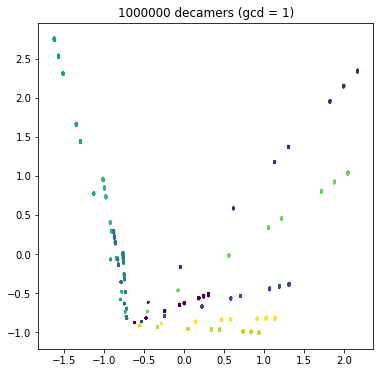

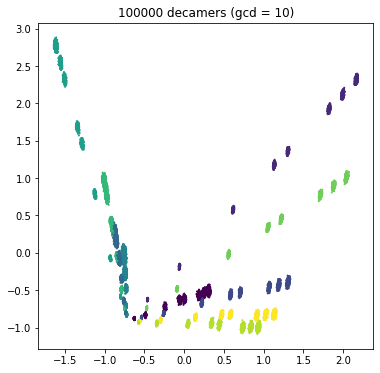

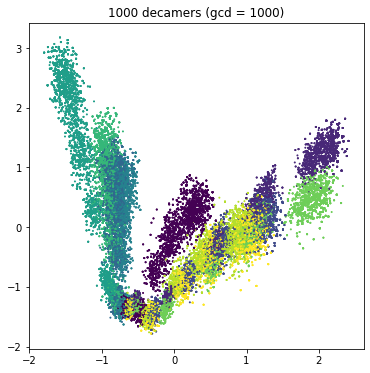

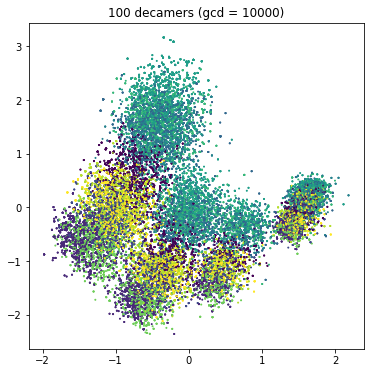

In [7]:
for scale in np.sort(train_df['gcd'].unique()):
    # Compute the PCA
    pca = PCA(whiten=True, random_state=1)
    pca.fit(train_i[elements][train_df['gcd'] == scale])

    # Transform the data so that the components can be analyzed
    Xt_tr = pca.transform(train_i[elements][train_df['gcd'] == scale])
    Xt_te = pca.transform(test_i[elements][test_df['gcd'] == scale])

    # Plot a scattergram, projected to two PCA components, colored by classification target
    plt.figure(figsize=(6,6))
    plt.scatter(Xt_tr[:,0], Xt_tr[:,1], c=train_df.target_num[train_df['gcd'] == scale], s=1)
    plt.title(f"{1000000 // scale} decamers (gcd = {scale})")
    plt.show()

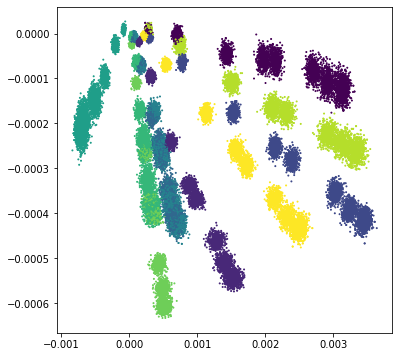

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(train_df.iloc[:,240][train_df['gcd'] == 1],
            train_df.iloc[:,181][train_df['gcd'] == 1],
            c=train_df.target_num[train_df['gcd'] == 1], s=1)
plt.show()

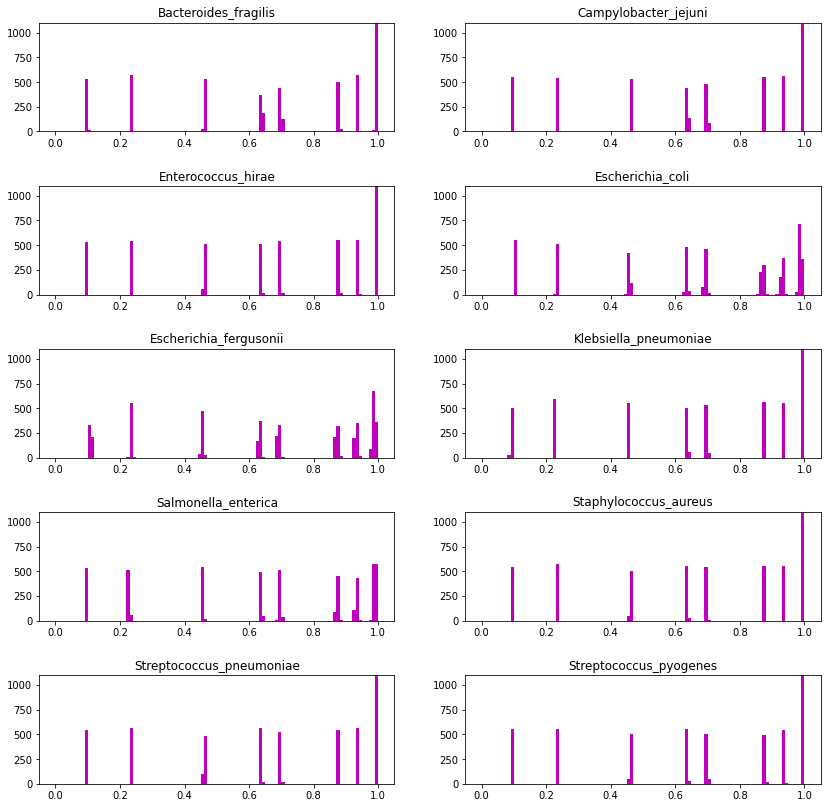

In [9]:
# Show how the spectra are scaled
# The original spectrum gives a peak at 1.0;
# the seven error rates give seven other peaks in the histograms
v = train_df[elements].abs().sum(axis=1)
plt.figure(figsize=(14, 14))
plt.tight_layout()
for t in range(10):
    plt.subplot(5, 2, t+1)
    vt = v[(train_df['gcd'] == 1) & (train_df['target_num'] == t)]
    plt.hist(vt / vt.max(), bins=np.linspace(0, 1, 101), color='m')
    plt.ylim(0, 1100)
    plt.title(le.inverse_transform([t])[0])
plt.subplots_adjust(hspace=0.5)
plt.show()

In [10]:
# Print the eight scalings (cluster centers) and the eight cluster sizes
for t in range(10):
    vt = v[(train_df['gcd'] == 1) & (train_df['target_num'] == t)]
    km = KMeans(n_clusters=8)
    km.fit(vt.values.reshape(-1, 1))
    print(sorted((km.cluster_centers_ / km.cluster_centers_.max()).ravel().round(2)),
          np.unique(km.predict(vt.values.reshape(-1, 1)), return_counts=True)[1][np.argsort(km.cluster_centers_.ravel())])

[0.1, 0.24, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 556  576  559  557  568  528  585 1145]
[0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 550  542  538  578  566  560  565 1083]
[0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 534  542  565  533  556  560  555 1111]
[0.11, 0.24, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 552  524  538  545  549  540  553 1095]
[0.11, 0.24, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 547  559  543  542  553  545  566 1127]
[0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 532  590  548  552  584  561  556 1109]
[0.1, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 534  574  562  539  558  554  552 1147]
[0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 545  576  549  575  548  556  553 1101]
[0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 548  563  580  585  543  548  568 1098]
[0.09, 0.23, 0.46, 0.64, 0.7, 0.88, 0.94, 1.0] [ 558  558  546  583  550  511  556 1129]


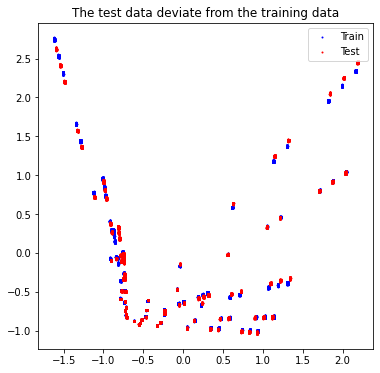

In [11]:
scale = 1

# Compute the PCA
pca = PCA(whiten=True, random_state=1)
pca.fit(train_i[elements][train_df['gcd'] == scale])

# Transform the data so that the components can be analyzed
Xt_tr = pca.transform(train_i[elements][train_df['gcd'] == scale])
Xt_te = pca.transform(test_i[elements][test_df['gcd'] == scale])

# Plot a scattergram, projected to two PCA components, colored by classification target
plt.figure(figsize=(6,6))
plt.scatter(Xt_tr[:,0], Xt_tr[:,1], c='b', s=1, label='Train')
plt.scatter(Xt_te[:,0], Xt_te[:,1], c='r', s=1, label='Test')
plt.title("The test data deviate from the training data")
plt.legend()
plt.show()

In [12]:
train_df.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target,target_num,gcd
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes,9,10000
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica,6,1000
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica,6,1
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica,6,1
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae,2,10000


In [13]:
test_df.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,gcd
0,200000,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,...,0.000085,0.000055,0.000108,0.000090,0.000059,0.000010,0.000006,0.000027,4.632568e-08,1
1,200001,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,0.001800,-0.000240,0.001800,-0.000114,0.000957,...,0.000914,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,1000
2,200002,4.632568e-08,0.000003,8.465576e-08,-0.000014,0.000007,-0.000005,-0.000004,0.000003,0.000004,...,0.000102,0.000084,0.000111,0.000117,0.000070,0.000020,0.000030,0.000021,4.632568e-08,1
3,200003,-9.536743e-07,-0.000008,8.084656e-06,0.000216,0.000420,0.000514,0.000452,0.000187,-0.000005,...,0.000158,0.000098,0.000175,0.000217,0.000150,0.000018,0.000016,0.000051,-9.536743e-07,1
4,200004,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,0.000914,-0.000043,-0.000010,-0.000010,0.000990,-9.536743e-07,1000


In [14]:
from pycaret.classification import *
df2 = train_df.sample(n=5000)
#import pandas_profiling
#train_df.profile_report()

In [15]:
df2

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target,target_num,gcd
165599,165599,-9.536743e-07,4.632568e-07,0.000017,0.000136,0.000070,0.000060,-0.000040,0.000066,-0.000013,4.632568e-07,-9.536743e-07,4.632568e-07,-0.000016,-0.000063,0.000229,0.000508,0.000578,0.000359,0.000047,-0.000006,4.632568e-07,-0.000003,-0.000113,-0.000162,0.000277,0.000676,0.001047,0.000728,-0.000003,-0.000023,-0.000044,-0.000241,0.000027,0.000245,0.001285,0.000867,0.000189,0.000026,-3.027161e-05,-0.000192,0.000076,0.000975,0.000496,0.000098,-7.027161e-05,0.000010,0.000228,0.000477,0.000407,0.000088,0.000060,0.000060,0.000519,0.000528,0.000469,2.972839e-05,0.000006,0.000337,0.000227,0.000016,0.000037,0.000144,0.000067,-0.000010,4.632568e-07,-9.536743e-07,-9.536743e-06,-0.000026,0.000077,0.000349,0.000388,0.000358,-0.000011,-0.000083,-0.000036,0.000010,-0.000046,-0.000197,0.000167,0.000973,0.001412,0.001093,-0.000103,-0.000107,-0.000056,-0.000193,-0.000713,0.000510,0.001494,0.002194,0.000650,-0.000553,-0.000093,-0.000281,-0.000507,0.000584,0.000608,0.000634,0.000183,-0.000151,-0.000142,-0.000418,0.000094,0.000934,0.000082,-0.000052,0.000058,0.000203,0.000990,0.000573,0.000108,0.000129,0.000547,0.000567,0.000239,0.000287,0.000533,0.000147,0.000174,0.000094,2.046326e-05,-0.000003,0.000187,0.000448,0.001247,0.000906,0.000137,-0.000162,-0.000123,-0.000033,-0.000123,-0.000283,0.000610,0.001474,0.001354,0.000150,-0.000623,-0.000113,-0.000332,-0.001490,-0.000494,0.00040

In [16]:
exp1 = setup(df2, target = 'target')

,Description,Value
0,session_id,8083
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,"Bacteroides_fragilis: 0, Campylobacter_jejuni: 1, Enterococcus_hirae: 2, Escherichia_coli: 3, Escherichia_fergusonii: 4, Klebsiella_pneumoniae: 5, Salmonella_enterica: 6, Staphylococcus_aureus: 7, Streptococcus_pneumoniae: 8, Streptococcus_pyogenes: 9"
4,Original Data,"(5000, 290)"
5,Missing Values,False
6,Numeric Features,289
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [17]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1040
qda,Quadratic Discriminant Analysis,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1760
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,41.5450
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,8.7580
et,Extra Trees Classifier,0.9600,0.9979,0.9591,0.9611,0.9598,0.9555,0.9557,0.4950
rf,Random Forest Classifier,0.9411,0.9958,0.9398,0.9430,0.9410,0.9346,0.9348,0.7050
lda,Linear Discriminant Analysis,0.7048,0.9395,0.7028,0.7321,0.7080,0.6717,0.6743,0.1440
nb,Naive Bayes,0.6568,0.9556,0.6509,0.6878,0.6480,0.6182,0.6231,0.0490
ridge,Ridge Classifier,0.4636,0.0000,0.4533,0.5188,0.3596,0.4018,0.4326,0.0420
ada,Ada Boost Classifier,0.4464,0.8360,0.4300,0.3234,0.3484,0.3827,0.4647,0.9930


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=8083, splitter='best')

In [18]:
rf = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [19]:
evaluate_model(rf)
#plot_model(rf, plot = 'auc')

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [20]:
tuned_rf = tune_model(rf)
#final_rf = finalize_model(rf)
#print(final_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [21]:
final_rf = finalize_model(tuned_rf)

In [22]:
#予測の実行
unseen_predictions = predict_model(final_rf, data = test_df)
print(test)

KeyError: "['target_num'] not in index"